In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import dataloaders as dl
import traintest as tt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
base_model = torch.load('base_model.pth').to(device)
robust_model = torch.load('gmm_model.pth').to(device)
robust_model_orig = torch.load('gmm_model.pth').to(device)

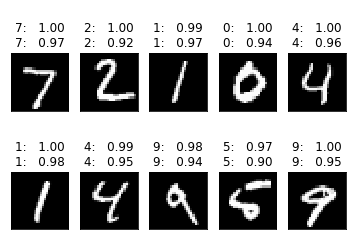

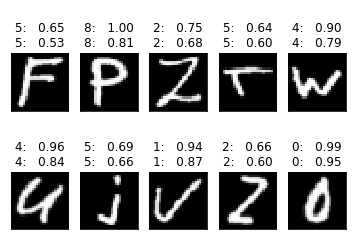

In [4]:
robust_model.log_pz_lam.data = torch.tensor(-5.).to(device)

data = enumerate(dl.test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)
    
data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)

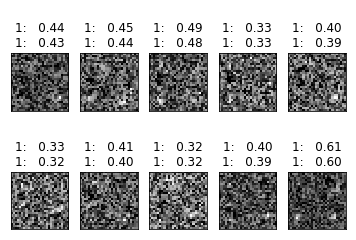

In [6]:
robust_model.eval()
perturbed_image = tt.generate_adv_noise(base_model, .9, device=device)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plotting.plot_samples([y_base, y], perturbed_image.detach().cpu())

In [ ]:
import torch

lr = .0001
momentum = .9

#optimizer = optim.SGD([{"params":robust_model.gmm.parameters()}, {"params":robust_model.log_pz_lam}], lr=lr, momentum=momentum)

optimizer = optim.SGD(robust_model.gmm.parameters(), lr=lr, momentum=momentum)


for epoch in range(2):
    optimizer.param_groups[0]['lr'] *= .8
    tt.train_adv(robust_model, device, dl.train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.406088
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.440984


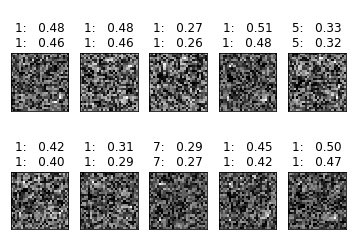

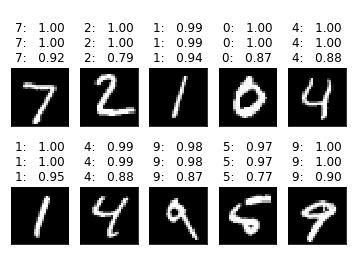

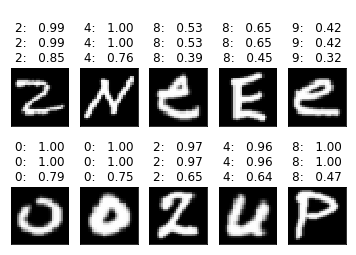

In [20]:


robust_model.eval()

perturbed_image = generate_adv_noise(robust_model.base_model, 3.)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plotting.plot_samples([y_base, y], perturbed_image.cpu())


data = enumerate(dl.test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y2 = robust_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y2 = robust_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


In [21]:
tt.test(robust_model, device, dl.test_loader)
tt.test(robust_model_orig, device, dl.test_loader)
tt.test(base_model, device, dl.test_loader)


Test set: Average loss: 0.1830, Accuracy: 9824/10000 (98%), Ave. Confidence: 85%


Test set: Average loss: 0.2450, Accuracy: 9779/10000 (98%), Ave. Confidence: 80%


Test set: Average loss: 0.0426, Accuracy: 9848/10000 (98%), Ave. Confidence: 98%



(9848, 0.9777726332187653)

In [22]:
tt.test_adv(robust_model, device, dl.EMNIST_test_loader)
tt.test_adv(robust_model_orig, device, dl.EMNIST_test_loader)
tt.test_adv(base_model, device, dl.EMNIST_test_loader)


Ave. Confidence: 60%


Ave. Confidence: 56%


Ave. Confidence: 79%



0.7927921631932259

In [23]:

like = robust_model.gmm(dl.X_MNIST[0:300].to(device))
like_E = robust_model.gmm(dl.X_EMNIST[0:300].to(device))

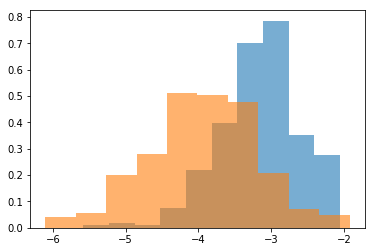

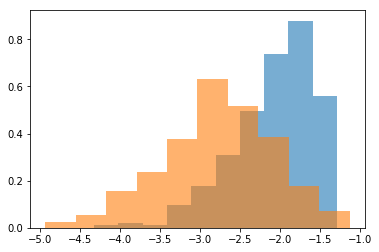

In [24]:
plt.hist(torch.logsumexp(like,dim=0).detach().cpu(), density=True, alpha=.6)
plt.hist(torch.logsumexp(like_E,dim=0).detach().cpu(), density=True, alpha=.6)
plt.show()

like2 = robust_model_orig.gmm(dl.X_MNIST[0:300].to(device))
like_E2 = robust_model_orig.gmm(dl.X_EMNIST[0:300].to(device))
plt.hist(torch.logsumexp(like2,dim=0).detach().cpu(), density=True, alpha=.6)
plt.hist(torch.logsumexp(like_E2,dim=0).detach().cpu(), density=True, alpha=.6)
plt.show()

In [25]:
robust_model.log_pz_lam

Parameter containing:
tensor(-5., device='cuda:0', requires_grad=True)

In [123]:
nearest_centroid_MNIST2 = (dl.X_MNIST[:,None,:]-robust_model_orig.gmm.mu.data.cpu()[None,:,:]).norm(dim=2).min(dim=1)[0]
nearest_centroid_EMNIST2 = (dl.X_EMNIST[:,None,:]-robust_model_orig.gmm.mu.data.cpu()[None,:,:]).norm(dim=2).min(dim=1)[0]

(array([ 38.,  92.,  79., 132., 344., 738., 829., 505., 203.,  40.]),
 array([ 1.68953097,  2.66607825,  3.64262552,  4.6191728 ,  5.59572008,
         6.57226735,  7.54881463,  8.52536191,  9.50190918, 10.47845646,
        11.45500374]),
 <a list of 10 Patch objects>)

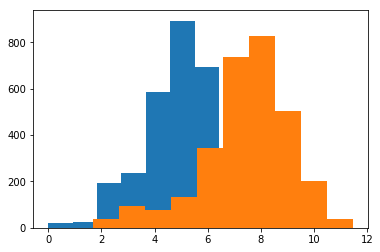

In [124]:

plt.hist(nearest_centroid_MNIST2)
plt.hist(nearest_centroid_EMNIST2)

In [26]:
robust_model.gmm.alpha.sum()

tensor(1.7476, device='cuda:0', grad_fn=<SumBackward0>)

In [11]:
(robust_model.gmm.mu-robust_model_orig.gmm.mu).mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward1>)

In [10]:
(robust_model.gmm.logvar-robust_model_orig.gmm.logvar).abs().max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [28]:
robust_model_orig.gmm.alpha.sum()

tensor(3., device='cuda:0', grad_fn=<SumBackward0>)

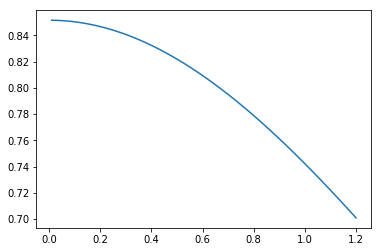

In [45]:
import numpy as np
xv = np.linspace(.01, 1.2,100)
plt.plot(xv, [robust_model.gmm.calculate_bound(x) for x in xv])

In [46]:
robust_model_orig.gmm.calculate_bound(80.)

tensor(-141.6205, device='cuda:0', grad_fn=<LogsumexpBackward>)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


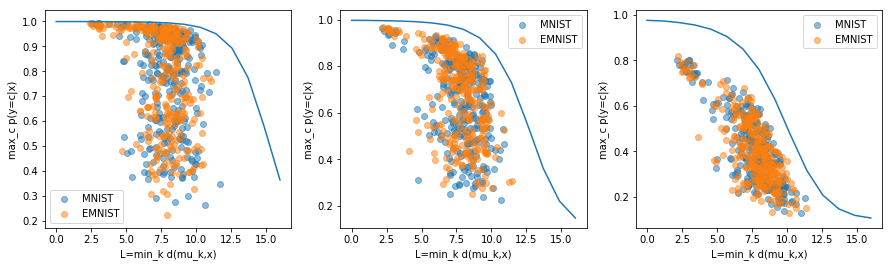

In [54]:
robust_model.log_pz_lam.data -= 5.
plt.figure(figsize=(15,4))


def bound(L):
    xi = (robust_model.gmm.calculate_bound(L)-robust_model.log_pz_lam).exp()
    return .1*(1+10*xi)/(1+xi)

for i in range(3):
    plt.subplot(1,3,i+1)
    robust_model.log_pz_lam.data += 2.
    xv = np.linspace(0, 16.,15.)
    bo = plt.plot(xv, [bound(x) for x in xv])

    n = 3
    data = []
    for _ in range(n):
        data.append(enumerate(dl.EMNIST_train_loader).__next__()[1][0])
    data = torch.cat(data, dim=0)
    Lv = (data.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]
    y = robust_model(data.to(device)).max(dim=1)[0].exp()
    ms = plt.scatter(Lv.detach(),y.detach().cpu().numpy(),alpha=.5)

    data = []
    for _ in range(n):
        data.append(enumerate(dl.EMNIST_train_loader).__next__()[1][0])
    data = torch.cat(data, dim=0)
    Lv = (data.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]
    y = robust_model(data.to(device)).max(dim=1)[0].exp()
    es = plt.scatter(Lv.detach(),y.detach().cpu().numpy(),alpha=.5)

    plt.xlabel('L=min_k d(mu_k,x)')
    plt.ylabel('max_c p(y=c|x)')
    plt.legend(( ms, es),
               ('MNIST', 'EMNIST'))

In [50]:
robust_model.log_pz_lam.data

tensor(-3., device='cuda:0')